Loaded rows: 2,794,503
After dropping NA: 2,794,502
Duplicate case numbers found and removed: 328


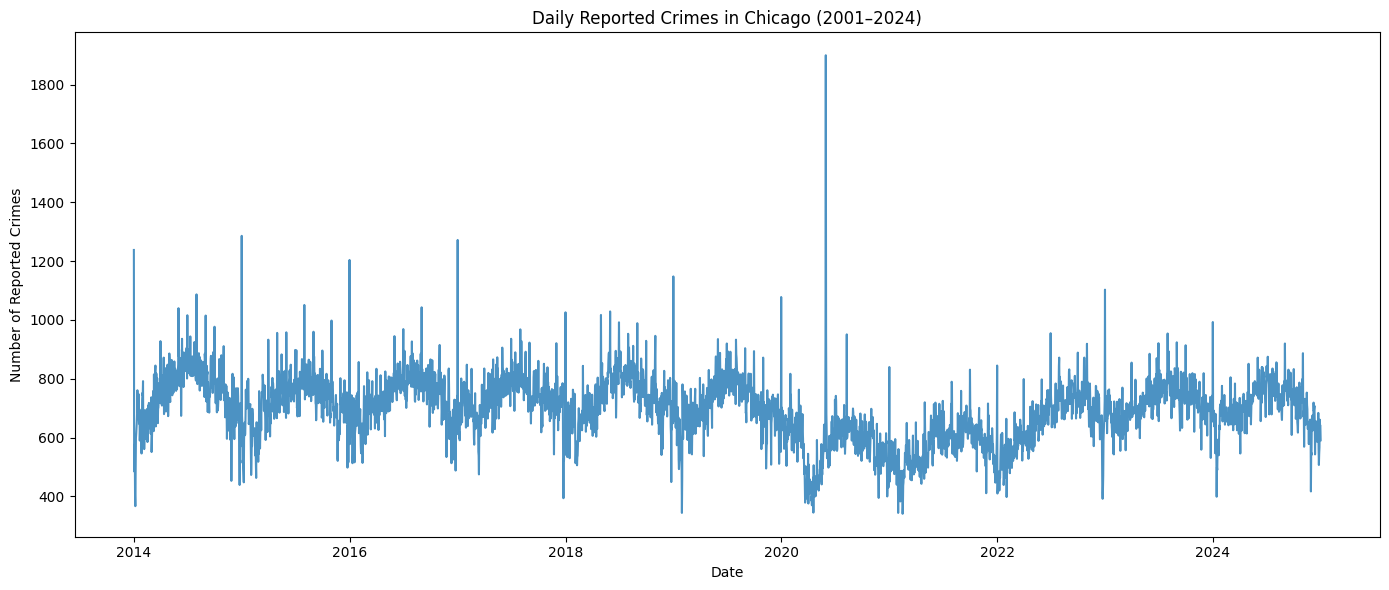

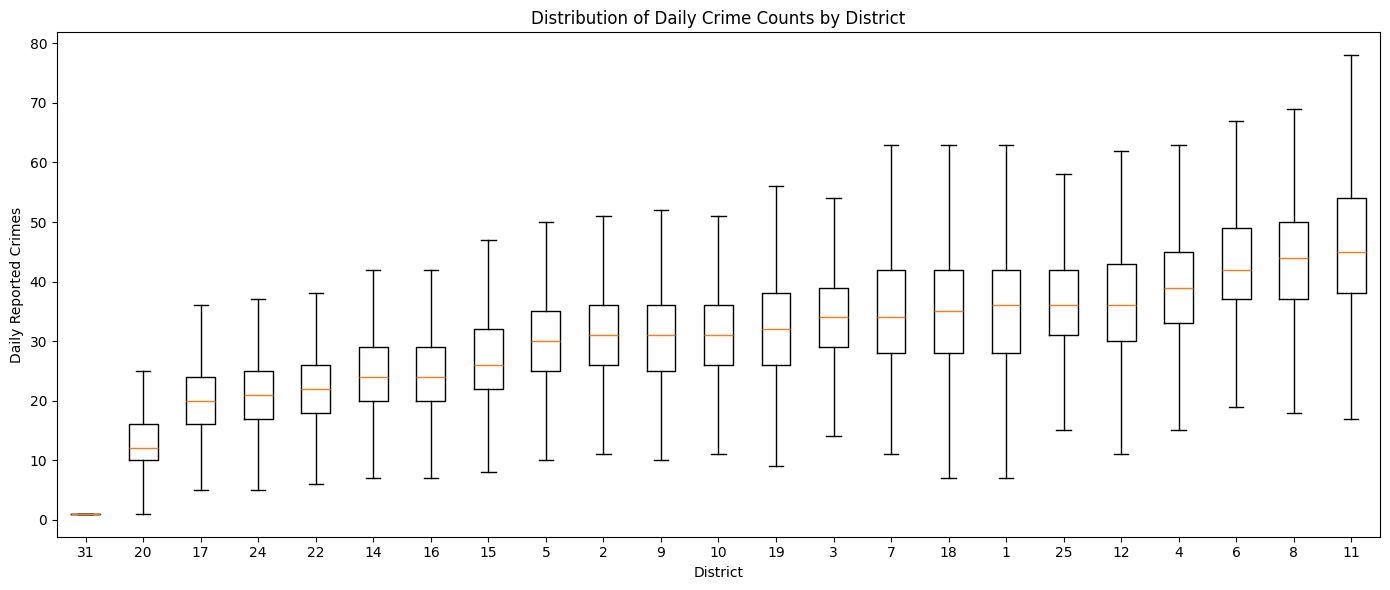

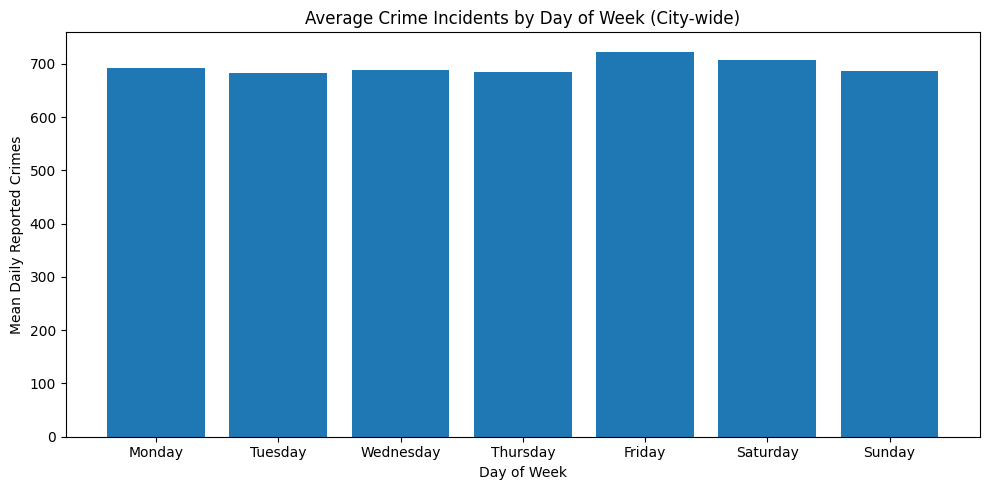

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

DATA_PATH = Path("Chicago.csv")           
OUT_DIR   = Path("outputs")             
OUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_csv(DATA_PATH, dtype={"Case Number": "string", "Primary Type": "string"})

df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y %I:%M:%S %p", errors="coerce")

n0 = len(df)
print(f"Loaded rows: {n0:,}")
df = df.dropna(subset=["Date", "Primary Type", "District"])
n_after_dropna = len(df)
print(f"After dropping NA: {n_after_dropna:,}")

if not pd.api.types.is_integer_dtype(df["District"]):
    df["District"] = pd.to_numeric(df["District"], errors="coerce").astype("Int64")
    df = df.dropna(subset=["District"])
    df["District"] = df["District"].astype(int)

dupes = df.duplicated(subset=["Case Number"]).sum()
print(f"Duplicate case numbers found and removed: {dupes:,}")
df = df.drop_duplicates(subset=["Case Number"])

df["DateOnly"]   = df["Date"].dt.date
df["Year"]       = df["Date"].dt.year
iso = df["Date"].dt.isocalendar()
df["ISO_Year"]   = iso.year.astype(int)
df["ISO_Week"]   = iso.week.astype(int)
df["DayOfWeek"]  = df["Date"].dt.day_name()

daily_counts = (
    df.groupby("DateOnly")
      .size()
      .rename("count")
      .reset_index()
      .sort_values("DateOnly")
)

weekly_counts = (
    df.groupby(["ISO_Year", "ISO_Week"])
      .size()
      .rename("count")
      .reset_index()
      .sort_values(["ISO_Year", "ISO_Week"])
)

district_daily = (
    df.groupby(["DateOnly", "District"])
      .size()
      .rename("count")
      .reset_index()
      .sort_values(["DateOnly", "District"])
)


theft_daily = (
    df.loc[df["Primary Type"] == "THEFT"] #for theft
      .groupby("DateOnly")
      .size()
      .rename("count")
      .reset_index()
 )

daily_counts.to_csv(OUT_DIR / "daily_counts.csv", index=False)
weekly_counts.to_csv(OUT_DIR / "weekly_counts.csv", index=False)
district_daily.to_csv(OUT_DIR / "district_daily.csv", index=False)

plt.figure(figsize=(14, 6))
plt.plot(daily_counts["DateOnly"], daily_counts["count"], alpha=0.8)
plt.title("Daily Reported Crimes in Chicago (2001–2024)")
plt.xlabel("Date")
plt.ylabel("Number of Reported Crimes")
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR / "fig_X1_daily_citywide.png", dpi=300)
plt.close()

district_order = (
    district_daily.groupby("District")["count"].median().sort_values().index.tolist()
)
plt.figure(figsize=(14, 6))
data_by_district = [district_daily.loc[district_daily["District"]==d, "count"].values
                    for d in district_order]
plt.boxplot(data_by_district, showfliers=False)
plt.xticks(ticks=np.arange(1, len(district_order)+1), labels=district_order, rotation=0)
plt.xlabel("District")
plt.ylabel("Daily Reported Crimes")
plt.title("Distribution of Daily Crime Counts by District")
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR / "fig_X2_boxplot_district_daily.png", dpi=300)
plt.close()

weekday_profile = (
    daily_counts.assign(weekday = pd.to_datetime(daily_counts["DateOnly"]).dt.day_name())
                .groupby("weekday")["count"].mean()
)

weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
weekday_profile = weekday_profile.reindex(weekday_order)

plt.figure(figsize=(10, 5))
plt.bar(weekday_profile.index, weekday_profile.values)
plt.xlabel("Day of Week")
plt.ylabel("Mean Daily Reported Crimes")
plt.title("Average Crime Incidents by Day of Week (City-wide)")
plt.tight_layout()
plt.show()
plt.savefig(OUT_DIR / "fig_X3_weekday_profile.png", dpi=300)
plt.close()

